# **Spaceship Titanic**

## **Librerías**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.display.max_columns = False

In [4]:
from datetime import datetime, timedelta
import winsound

In [5]:
import sys
import warnings

In [6]:
sys.path.append('C:/Users/jmart/OneDrive/Documentos/Proyectos/Proyectos_Web/Utils')

In [7]:
warnings.filterwarnings("ignore")

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [9]:
import xgboost as xgb

## **Datos**

In [19]:
train_df = pd.read_csv('./Datos/Model_Data.csv')

### **Preparando los datos para el modelo**

In [20]:
home_planet_dum = pd.get_dummies(train_df['HomePlanet'])
destination_dum = pd.get_dummies(train_df['Destination'])
cabin_I_dum = pd.get_dummies(train_df['Cabin_Type'])
cabin_II_dum = pd.get_dummies(train_df['Cabin_Type_2'])

In [21]:
X = train_df.drop(
    ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Cabin_Type', 'Cabin_Type_2'], 
    axis=1
)

In [22]:
X = pd.merge(X.reset_index(), home_planet_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, destination_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, cabin_I_dum.reset_index(), how='left', left_on='index', right_on='index')
X = pd.merge(X, cabin_II_dum.reset_index(), how='left', left_on='index', right_on='index')

In [23]:
X.drop(['index', 'Unknown_x', 'Unknown_y', 'Unknown_x', 'Unknown_y', 'Transported'], axis=1, inplace=True)

## **Modelo**

In [24]:
train_df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [25]:
y = train_df['Transported']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, train_size=0.8)

### **1. Random Forest**

In [27]:
random_forest = RandomForestClassifier(random_state=13)

In [28]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=13)

In [29]:
y_pred = random_forest.predict(X_test)

In [30]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       921
           1       0.76      0.80      0.78       818

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



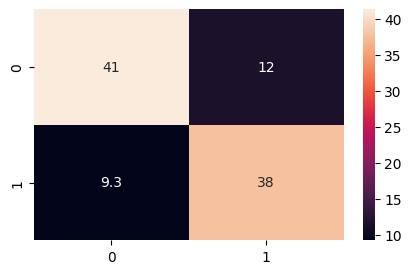

In [33]:
plt.subplots(figsize=(5, 3))
sns.heatmap((confusion_matrix(y_pred, y_test)/len(X_test))*100, annot=True)
plt.show()

In [34]:
feature_importance = random_forest.feature_importances_
feature_names=X.columns
dic_feature_importance = {
                        'feature_importance':feature_importance ,
                        'feature_names':feature_names }
feature_importance_DF= pd.DataFrame(dic_feature_importance).sort_values(by='feature_importance',ascending=False)
feature_importance_DF.head(5)

,feature_importance,feature_names
1,0.176832,Age
6,0.127403,Spa
3,0.121280,RoomService
7,0.111661,VRDeck
4,0.101729,FoodCourt


#### **Grid Search**

In [35]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 3, 4, 5]
}

In [36]:
rf_model = RandomForestClassifier()

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3)

In [37]:
%%time
grid_search_rf.fit(X_train, y_train)

CPU times: total: 9min 16s
Wall time: 11min 28s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 9, 11],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [39]:
y_pred_gs = grid_search_rf.predict(X_test)

In [40]:
print(classification_report(y_pred_gs, y_test))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       851
           1       0.82      0.79      0.80       888

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



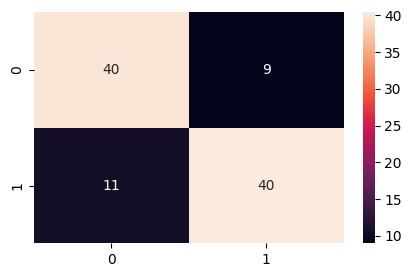

In [42]:
plt.subplots(figsize=(5, 3))
sns.heatmap((confusion_matrix(y_pred_gs, y_test)/len(X_test))*100, annot=True)
plt.show()

In [43]:
print("Mejor conjunto de parámetros: ", grid_search_rf.best_params_)
print("Mejor puntaje: ", grid_search_rf.best_score_)

Mejor conjunto de parámetros:  {'max_depth': 9, 'min_samples_split': 5, 'n_estimators': 400}
Mejor puntaje:  0.7992522289329882


In [44]:
accuracy = accuracy_score(y_pred_gs, y_test)

In [45]:
accuracy

0.8039102932719954

### **2. XGBoost**

In [46]:
xgb_model = xgb.XGBClassifier()

In [47]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [48]:
y_pred_xgb = xgb_model.predict(X_test)

In [49]:
print(classification_report(y_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       852
           1       0.81      0.78      0.79       887

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



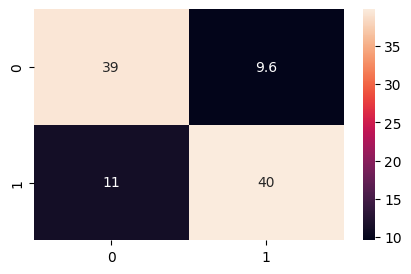

In [50]:
plt.subplots(figsize=(5, 3))
sns.heatmap((confusion_matrix(y_pred_xgb, y_test)/len(X_test))*100, annot=True)
plt.show()

In [51]:
feature_importance = xgb_model.feature_importances_
feature_names=X.columns
dic_feature_importance = {
                        'feature_importance':feature_importance ,
                        'feature_names':feature_names }
feature_importance_DF= pd.DataFrame(dic_feature_importance).sort_values(by='feature_importance',ascending=False)
feature_importance_DF.head(5)

,feature_importance,feature_names
0,0.482335,CryoSleep
8,0.136177,Earth
9,0.056408,Europa
18,0.040587,E
10,0.025851,Mars


#### **Grid Search**

In [52]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [7, 9, 11],
    'n_estimators': [100, 200, 300]
}

In [53]:
xgb_model_gs = xgb.XGBClassifier()

In [54]:
grid_search_xgb = GridSearchCV(xgb_model_gs, param_grid, cv=3)

In [55]:
%%time
grid_search_xgb.fit(X_train, y_train)

CPU times: total: 7min 30s
Wall time: 4min 46s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...in=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [7, 9, 11],
                         'n_estimators': [100, 200, 300]})

In [56]:
print("Mejor conjunto de parámetros: ", grid_search_xgb.best_params_)
print("Mejor puntaje: ", grid_search_xgb.best_score_)

Mejor conjunto de parámetros:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
Mejor puntaje:  0.7976704055220017


In [57]:
y_pred_xgb_gs = grid_search_xgb.predict(X_test)

In [58]:
print(classification_report(y_pred_xgb_gs, y_test))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       836
           1       0.81      0.77      0.79       903

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



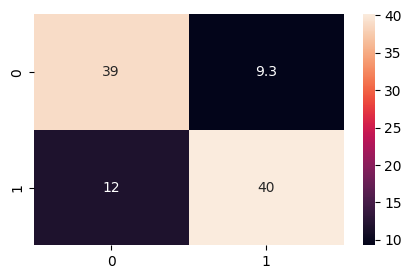

In [60]:
plt.subplots(figsize=(5, 3))
sns.heatmap((confusion_matrix(y_pred_xgb_gs, y_test)/len(X_test))*100, annot=True)
plt.show()

### **3. Bagging**

In [61]:
decision_tree = DecisionTreeClassifier()

In [62]:
bagging = BaggingClassifier(base_estimator=decision_tree, n_estimators=100, random_state=0)

In [63]:
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=0)

In [67]:
y_pred_bagg = bagging.predict(X_test)

In [68]:
print(classification_report(y_pred_bagg, y_test))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       895
           1       0.79      0.80      0.79       844

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



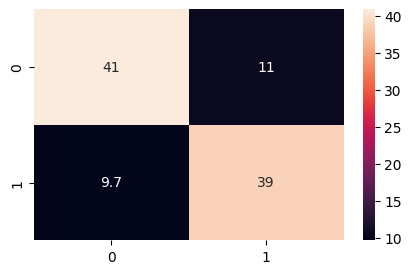

In [69]:
plt.subplots(figsize=(5, 3))
sns.heatmap((confusion_matrix(y_pred_bagg, y_test)/len(X_test))*100, annot=True)
plt.show()

In [70]:
accuracy = accuracy_score(y_pred_bagg, y_test)

In [71]:
accuracy

0.79700977573318

## **Modelo en dos fases**

In [95]:
df = pd.merge(X.reset_index(), train_df[['Transported']].reset_index(), how='left')

In [96]:
df.drop('index', axis=1, inplace=True)

In [97]:
df_0 = df.query('CryoSleep == 0').copy()
df_1 = df.query('CryoSleep == 1').copy()

In [98]:
X_0 = df_0.drop('Transported', axis=1)
X_1 = df_1.drop('Transported', axis=1)

In [99]:
y_0 = df_0['Transported']
y_1 = df_1['Transported']

In [100]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, random_state=13, train_size=0.8)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state=13, train_size=0.8)

### **1. Random Forest**

In [101]:
random_forest_0 = RandomForestClassifier(random_state=13)
random_forest_1 = RandomForestClassifier(random_state=13)

In [103]:
random_forest_0.fit(X_0_train.drop('CryoSleep', axis=1), y_0_train)
random_forest_1.fit(X_1_train.drop('CryoSleep', axis=1), y_1_train)

RandomForestClassifier(random_state=13)

In [104]:
y_pred_0 = random_forest_0.predict(X_0_test.drop('CryoSleep', axis=1))
y_pred_1 = random_forest_1.predict(X_1_test.drop('CryoSleep', axis=1))

In [105]:
print(classification_report(y_pred_0, y_0_test))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       834
           1       0.54      0.70      0.61       298

    accuracy                           0.77      1132
   macro avg       0.71      0.75      0.72      1132
weighted avg       0.79      0.77      0.78      1132



In [106]:
print(classification_report(y_pred_1, y_1_test))

              precision    recall  f1-score   support

           0       0.31      0.38      0.34        90
           1       0.89      0.85      0.87       518

    accuracy                           0.78       608
   macro avg       0.60      0.62      0.61       608
weighted avg       0.80      0.78      0.79       608



In [107]:
X_test.reset_index(drop = True, inplace=True)

In [108]:
resultados = []

for i in range(X_test.shape[0]):
    if X_test.iloc[i, 0] == 0:
        prediction = random_forest_0.predict(X_test.drop('CryoSleep', axis=1).loc[i:i])[0]
        resultados.append(prediction)
    elif X_test.iloc[i, 0] == 1:
        prediction = random_forest_1.predict(X_test.drop('CryoSleep', axis=1).loc[i:i])[0]
        resultados.append(prediction)

In [109]:
y_test_final = np.array(resultados)

In [110]:
print(classification_report(y_test_final, y_test))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       862
           1       0.94      0.92      0.93       877

    accuracy                           0.93      1739
   macro avg       0.93      0.93      0.93      1739
weighted avg       0.93      0.93      0.93      1739



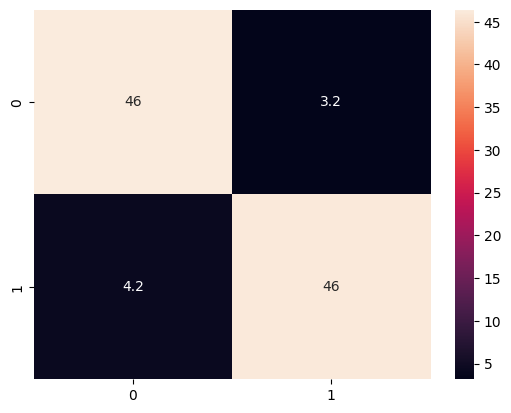

In [111]:
sns.heatmap((confusion_matrix(y_test_final, y_test)/len(X_test))*100, annot=True)
plt.show()

In [112]:
accuracy = accuracy_score(y_test_final, y_test)

In [113]:
accuracy

0.926394479585969

#### **Grid Search**

In [114]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 3, 4, 5]
}

In [115]:
rf_model_0 = RandomForestClassifier()
rf_model_1 = RandomForestClassifier()

grid_search_rf_0 = GridSearchCV(rf_model_0, param_grid_rf, cv=3)
grid_search_rf_1 = GridSearchCV(rf_model_1, param_grid_rf, cv=3)

In [ ]:
grid_search_rf_0.fit(X_0_train.drop('CryoSleep', axis=1), y_0_train)
grid_search_rf_1.fit(X_1_train.drop('CryoSleep', axis=1), y_1_train)

In [ ]:
y_pred_gs_0 = grid_search_rf_0.predict(X_0_test.drop('CryoSleep', axis=1))
y_pred_gs_1 = grid_search_rf_0.predict(X_1_test.drop('CryoSleep', axis=1))

In [ ]:
print(classification_report(y_pred_gs_0, y_0_test))

In [ ]:
print(classification_report(y_pred_gs_1, y_1_test))

In [ ]:
accuracy_0 = accuracy_score(y_pred_gs_0, y_0_test)
accuracy_1 = accuracy_score(y_pred_gs_1, y_1_test)

In [ ]:
accuracy_0, accuracy_1

In [ ]:
resultados = []

for i in range(X_test.shape[0]):
    if X_test.iloc[i, 0] == 0:
        prediction = grid_search_rf_0.predict(X_test.drop('CryoSleep', axis=1).loc[i:i])[0]
        resultados.append(prediction)
    elif X_test.iloc[i, 0] == 1:
        prediction = grid_search_rf_1.predict(X_test.drop('CryoSleep', axis=1).loc[i:i])[0]
        resultados.append(prediction)

In [ ]:
y_test_final = np.array(resultados)

In [ ]:
print(classification_report(y_test_final, y_test))

In [ ]:
sns.heatmap((confusion_matrix(y_test_final, y_test)/len(X_test))*100, annot=True)
plt.show()

In [ ]:
accuracy = accuracy_score(y_test_final, y_test)

In [ ]:
accuracy

## **Resultados**

In [ ]:
test_kaggle = pd.read_csv('./Datos/test.csv')

In [ ]:
test_kaggle.sample()

### **Limpieza y Preparación de Datos**

In [ ]:
# Planeta natal
test_kaggle['HomePlanet'].fillna('Unknown', inplace=True)

# Sueño criogenico
test_kaggle['CryoSleep'].fillna('Unknown', inplace=True)

In [ ]:
def calc_detail_cabin(x, position):
	# Divides la cadena en subcadenas utilizando '/' como separador y devuelve el primer elemento
	try:
		return x.split('/')[position]        
	# Si ocurre algún error al intentar dividir la cadena, se devuelve la cadena original
	except:
		return x

In [ ]:
# Información de la cabina
test_kaggle['Cabin'].fillna('Unknown', inplace=True)
test_kaggle['Cabin_Type'] = test_kaggle['Cabin'].apply(lambda x: calc_detail_cabin(x, 0))
test_kaggle['Cabin_Type_2'] = test_kaggle['Cabin'].apply(lambda x: calc_detail_cabin(x, 2))

In [ ]:
# Destino
test_kaggle['Destination'].fillna('Unknown', inplace=True)

In [ ]:
#Edad
test_kaggle['Age'].fillna(round(test_kaggle['Age'].mean()), inplace=True)

In [ ]:
# VIP
test_kaggle['VIP'].fillna('Unknown', inplace=True)

In [ ]:
# Variables numéricas $$
test_kaggle['RoomService'].fillna(0, inplace=True)
test_kaggle['FoodCourt'].fillna(0, inplace=True)
test_kaggle['ShoppingMall'].fillna(0, inplace=True)
test_kaggle['Spa'].fillna(0, inplace=True)
test_kaggle['VRDeck'].fillna(0, inplace=True)

In [ ]:
# Eliminamos el nombre
test_kaggle.drop('Name', axis= 1, inplace=True)

### **Preparando los datos para el modelo**

In [ ]:
test_kaggle['CryoSleep'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)
test_kaggle['VIP'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)

In [ ]:
home_planet_dum = pd.get_dummies(test_kaggle['HomePlanet'])
destination_dum = pd.get_dummies(test_kaggle['Destination'])
cabin_I_dum = pd.get_dummies(test_kaggle['Cabin_Type'])
cabin_II_dum = pd.get_dummies(test_kaggle['Cabin_Type_2'])

In [ ]:
X_kaggle = test_kaggle.drop(
    ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Cabin_Type', 'Cabin_Type_2'], 
    axis=1
)

In [ ]:
X_kaggle = pd.merge(X_kaggle.reset_index(), home_planet_dum.reset_index(), how='left', left_on='index', right_on='index')
X_kaggle = pd.merge(X_kaggle, destination_dum.reset_index(), how='left', left_on='index', right_on='index')
X_kaggle = pd.merge(X_kaggle, cabin_I_dum.reset_index(), how='left', left_on='index', right_on='index')
X_kaggle = pd.merge(X_kaggle, cabin_II_dum.reset_index(), how='left', left_on='index', right_on='index')

In [ ]:
X_kaggle.drop(['index', 'Unknown_x', 'Unknown_y', 'Unknown_x', 'Unknown_y'], axis=1, inplace=True)

In [ ]:
resultados_kaggle = []

for i in range(X_kaggle.shape[0]):
    if X_kaggle.iloc[i, 0] == 0:
        prediction = grid_search_rf_0.predict(X_kaggle.drop('CryoSleep', axis=1).loc[i:i])[0]
        resultados_kaggle.append(prediction)
    elif X_kaggle.iloc[i, 0] == 1:
        prediction = grid_search_rf_1.predict(X_kaggle.drop('CryoSleep', axis=1).loc[i:i])[0]
        resultados_kaggle.append(prediction)

In [ ]:
prediccion_final_kaggle = pd.DataFrame(resultados_kaggle)
prediccion_final_kaggle.columns = ['Transported']

In [ ]:
final = pd.merge(test_kaggle[['PassengerId']].reset_index(), prediccion_final_kaggle.reset_index())
final.drop('index', axis=1, inplace=True)

In [ ]:
final['Transported'] = np.where(final['Transported'] == 1, True, False)

In [ ]:
final.to_csv('./Datos/Resultados_002.csv', index=False)